<a href="https://colab.research.google.com/github/AnIsAsPe/LogisticRegression_SpamOpinion/blob/master/Notebooks/Clasificador_rese%C3%B1as_Regresi%C3%B3n_log%C3%ADstica_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Funciones

In [ ]:
def elimina_stopwords(texto):
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [ ]:
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub('[^a-z]+', ' ', texto)
  return nuevo_texto


In [ ]:


def lematizar(texto):
  lemma = WordNetLemmatizer()
  texto=texto.split()
  nuevo_texto = " ".join([lemma.lemmatize(i) for i in texto])
  return nuevo_texto

In [ ]:
def stemmer(texto):
  st = PorterStemmer()
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])
  return nuevo_texto

In [ ]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)


# Lectura de datos y breve exploración

In [ ]:
datos = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv',
                     usecols=['deceptive','text']
                    )
print(datos.shape)
datos.head()

(1600, 2)


,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   text       1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB


In [ ]:
datos.deceptive.value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [ ]:
# datos['deceptive'] = np.where(datos['deceptive']=='deceptive', 1, 0)
# datos['deceptive'].value_counts()

In [ ]:
y = datos['deceptive']

# Preprocesamiento de texto

In [ ]:
datos['text']

0       We stayed for a one night getaway with family ...
1       Triple A rate with upgrade to view room was le...
2       This comes a little late as I'm finally catchi...
3       The Omni Chicago really delivers on all fronts...
4       I asked for a high floor away from the elevato...
                              ...                        
1595    Problems started when I booked the InterContin...
1596    The Amalfi Hotel has a beautiful website and i...
1597    The Intercontinental Chicago Magnificent Mile ...
1598    The Palmer House Hilton, while it looks good i...
1599    As a former Chicagoan, I'm appalled at the Ama...
Name: text, Length: 1600, dtype: object

In [ ]:
datos['long_text'] = datos['text'].str.len()

In [ ]:
datos 

,deceptive,text,long_text
0,truthful,We stayed for a one night getaway with family ...,572
1,truthful,Triple A rate with upgrade to view room was le...,286
2,truthful,This comes a little late as I'm finally catchi...,1104
3,truthful,The Omni Chicago really delivers on all fronts...,707
4,truthful,I asked for a high floor away from the elevato...,384
...,...,...,...
1595,deceptive,Problems started when I booked the InterContin...,746
1596,deceptive,The Amalfi Hotel has a beautiful website and i...,671
1597,deceptive,The Intercontinental Chicago Magnificent Mile ...,771
1598,deceptive,"The Palmer House Hilton, while it looks good i...",449


In [ ]:
indice = 0
ejemplo = datos.loc[indice, 'text']
print(len(ejemplo))
ejemplo

572


'We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n'

#### Transformar texto a minúsculas

In [ ]:
ejemplo = ejemplo.lower()
print(len(ejemplo))
ejemplo

572


'we stayed for a one night getaway with family on a thursday. triple aaa rate of 173 was a steal. 7th floor room complete with 44in plasma tv bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) concierge was very helpful. you cannot beat this location... only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. food was very good so it was worth the wait. i would return in a heartbeat. a gem in chicago... \n'

#### Quitar puntuación

In [ ]:
ejemplo = elimina_puntuacion_y_numeros(ejemplo)
print(len(ejemplo))
ejemplo

547


'we stayed for a one night getaway with family on a thursday triple aaa rate of was a steal th floor room complete with in plasma tv bose stereo voss and evian water and gorgeous bathroom no tub but was fine for us concierge was very helpful you cannot beat this location only flaw was breakfast was pricey and service was very very slow hours for four kids and four adults on a friday morning even though there were only two other tables in the restaurant food was very good so it was worth the wait i would return in a heartbeat a gem in chicago '

#### Quitar Palabras Irrelevantes ("Stopwords")

In [ ]:
ejemplo = elimina_stopwords(ejemplo)
print(len(ejemplo))
ejemplo

362


'stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom tub fine us concierge helpful cannot beat location flaw breakfast pricey service slow hours four kids four adults friday morning even though two tables restaurant food good worth wait would return heartbeat gem chicago '

## Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

Referencia: 

https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc

In [ ]:
ejemplo_lema = lematizar(ejemplo)
print(len(ejemplo))
ejemplo_lema

362


'stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom tub fine u concierge helpful cannot beat location flaw breakfast pricey service slow hour four kid four adult friday morning even though two table restaurant food good worth wait would return heartbeat gem chicago'

In [ ]:
ejemplo_stem = stemmer(ejemplo)
print(len(ejemplo))
ejemplo_stem

362


'stay one night getaway famili thursday tripl aaa rate steal th floor room complet plasma tv bose stereo voss evian water gorgeou bathroom tub fine us concierg help cannot beat locat flaw breakfast pricey servic slow hour four kid four adult friday morn even though two tabl restaur food good worth wait would return heartbeat gem chicago'

## Todo junto

In [ ]:
datos['text_pp'] = datos['text'].apply(preprocesar)
datos['long_text_pp'] = datos['text_pp'].str.len()
datos.head()

,deceptive,text,long_text,text_pp,long_text_pp
0,truthful,We stayed for a one night getaway with family ...,572,stay one night getaway famili thursday tripl a...,340
1,truthful,Triple A rate with upgrade to view room was le...,286,tripl rate upgrad view room less also includ b...,186
2,truthful,This comes a little late as I'm finally catchi...,1104,come littl late final catch review past sever ...,624
3,truthful,The Omni Chicago really delivers on all fronts...,707,omni chicago realli deliv front spacious room ...,387
4,truthful,I asked for a high floor away from the elevato...,384,ask high floor away elev got room pleasantli d...,197


# Visualización de nubes de palabras

In [ ]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text= " ".join(review for review in sec_textos)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          background_color="white").generate(text)

    # Desplegar la imagen generada
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

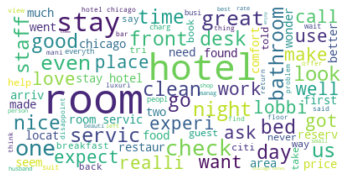

In [ ]:
nube_palabras(datos['text_pp'])

In [ ]:
porClase = datos.groupby('deceptive')
verdaderas = porClase.get_group('truthful').text_pp
falsas = porClase.get_group('deceptive').text_pp

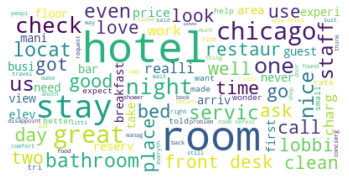

In [ ]:
nube_palabras(verdaderas)

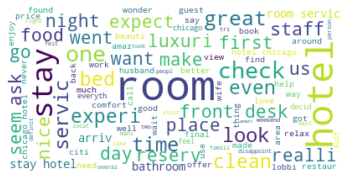

In [ ]:
nube_palabras(falsas)

# Vectorización de Texto mediante BOW

In [ ]:
vectorizer = TfidfVectorizer(min_df=2)
BOW = vectorizer.fit_transform(datos['text_pp'])
BOW.shape

(1600, 3616)

In [ ]:
palabras = vectorizer.get_feature_names_out()
X = pd.DataFrame(BOW.todense(), index=datos.index, columns=palabras)
X

,aaa,abil,abl,abrupt,absenc,absent,absolut,absurd,abund,abysm,ac,accent,accept,access,accident,accomad,accomid,accommod,accomod,accompani,accomplish,accord,account,accur,accus,accustom,ach,acknowledg,acquaint,across,act,action,activ,actual,ad,add,addit,address,adequ,adjac,...,worn,worri,wors,worst,worth,worthi,woudl,would,wouldnt,wow,wrap,wrigley,wrinkl,write,written,wrong,wrote,ye,yeah,year,yearli,yell,yellow,yelp,yep,yesterday,yet,yield,yoga,yogurt,york,young,younger,yr,yuck,yummi,yup,zest,zone,zoo
0,0.1882,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.111565,0.0,0.0,0.056084,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.304154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,0.0,0.084973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.043475,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.181761,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096682,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1596,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136929,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.128338,0.0,0.0,0.129032,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.111367,0.0,0.0,0.0,0.0,0.154996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.162156,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1598,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158

# Regresión Logística sin penalización

In [ ]:
# Dividir datos en entrenamiento y prueba
X_train, X_test , y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True,   
                                                     random_state=9
                                                     )

clasificador_rl = LogisticRegression(penalty= 'none',
                                     random_state=4, 
                                     solver="newton-cg").fit(X_train, y_train)
clasificador_rl.score(X_test, y_test)

0.85625

In [ ]:
def evaluación(modelo, conjunto):
    mensaje_error = 'conjunto solo puede ser "entrenamieonto" o "prueba"'
    assert conjunto in ['entrenamiento', 'prueba'], mensaje_error


    if conjunto == 'entrenamiento':
      X = X_train
      y = y_train
    else:
      X = X_test
      y = y_test    
   

    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred)*100

    # creamos un diccionario con las etiquetas
    data = {'y_Real':  y,
            'y_Prediccion': y_pred
            }
    # lo convertimos en un DataFrame de pandas
    df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

    # hacemos una tabla crusada para obtener la matriz de confusión
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'], 
                                   rownames=['Real'], colnames=['Predicción'])

    # realizamos un mapa de calor
    titulo = 'Datos:{}, precisión = {:4.2f}'.format(conjunto, precision)
    sns.heatmap(confusion_matrix, annot=True, fmt='g').set(title = titulo)
    plt.show()


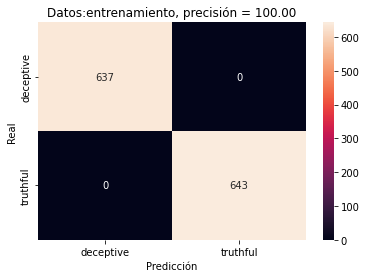

In [ ]:
evaluación(clasificador_rl, 'entrenamiento')

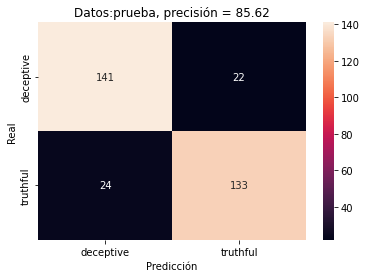

In [ ]:
evaluación(clasificador_rl, 'prueba')

# Regresión Logística con penalización Ridge

## ¿De qué magnitud debe ser la fueza de la regularización (parámetro  λ)?

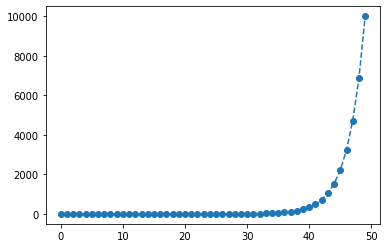

In [ ]:
lambdas = np.logspace(-4, 4, 50)
plt.plot(lambdas, linestyle='--', marker='o')
plt.show()

In [ ]:
lambdas

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LogisticRegression(penalty='l2',max_iter=500), 
                           { 'C': 1/lambdas}, cv=5, return_train_score=False)
grid_search.fit(X, y)

CPU times: user 2min 46s, sys: 41.5 s, total: 3min 27s
Wall time: 1min 48s


In [ ]:
grid_search.best_params_

{'C': 3.7275937203149416}

In [ ]:
C = grid_search.best_params_['C']

# valor de lambda
1 / grid_search.best_params_['C']

0.2682695795279725

In [ ]:
clasificador_ridge = LogisticRegression(penalty= 'l2',  
                                        C = C, 
                                        random_state=4, 
                                        solver="newton-cg").fit(X_train, y_train)

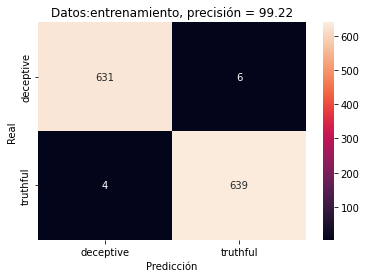

In [ ]:
evaluación(clasificador_ridge, 'entrenamiento')

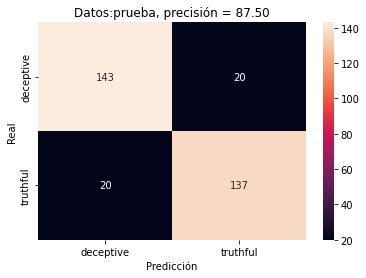

In [ ]:
evaluación(clasificador_ridge, 'prueba')

# Predicciones y certeza de la predicción

In [ ]:
resultados = {'P(deceptive)' : clasificador_rl.predict_proba(X_test)[:,0],
              'P(truthful)' : clasificador_rl.predict_proba(X_test)[:,1], 
              'y_pred_50' : clasificador_rl.predict(X_test),          
              }

predicciones = pd.DataFrame(resultados)
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[155:165]

,P(deceptive),P(truthful),y_pred_50
132,0.736305,0.263695,deceptive
153,0.728104,0.271896,deceptive
149,0.682137,0.317863,deceptive
313,0.645260,0.354740,deceptive
205,0.640744,0.359256,deceptive
191,0.614963,0.385037,deceptive
286,0.582905,0.417095,deceptive
102,0.558283,0.441717,deceptive
22,0.543162,0.456838,deceptive
224,0.522063,0.477937,deceptive


In [ ]:
predicciones['y_pred_60'] = np.where( predicciones['P(deceptive)'] > .6, 'deceptive', 'truthful')
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[155:165]

,P(deceptive),P(truthful),y_pred_50,y_pred_60
132,0.736305,0.263695,deceptive,deceptive
153,0.728104,0.271896,deceptive,deceptive
149,0.682137,0.317863,deceptive,deceptive
313,0.645260,0.354740,deceptive,deceptive
205,0.640744,0.359256,deceptive,deceptive
191,0.614963,0.385037,deceptive,deceptive
286,0.582905,0.417095,deceptive,truthful
102,0.558283,0.441717,deceptive,truthful
22,0.543162,0.456838,deceptive,truthful
224,0.522063,0.477937,deceptive,truthful


## PENDIENTE Curva ROC

In [ ]:
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)  
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()



In [ ]:
grafica_roc(clasificador_ridge, y_test )

ValueError: ignored

# Magnitud de los coeficientes para ambos modelos

In [ ]:
coeficientes_rl = pd.Series(clasificador_rl.coef_[0], 
                            index=palabras,
                            name='Sin regularización').sort_values(ascending=False)
coeficientes_rl

floor         37.788578
street        36.411060
locat         34.536465
small         31.756317
elev          31.142357
                ...    
definit      -27.971250
relax        -28.005217
millennium   -30.007903
luxuri       -40.155852
chicago      -60.849421
Name: Sin regularización, Length: 3616, dtype: float64

In [ ]:
coeficientes_ridge = pd.Series(clasificador_ridge.coef_[0],
                               index=palabras,
                               name='Ridge').sort_values(ascending=False)
coeficientes_ridge

locat      3.669680
floor      3.626754
elev       3.157466
small      3.080319
street     2.926056
             ...   
seem      -2.784388
relax     -2.809551
experi    -3.038623
luxuri    -4.518904
chicago   -6.871216
Name: Ridge, Length: 3616, dtype: float64

In [ ]:
# Observa las magnitudes de los coeficientes del modelo
#  sin y con regularización Ridge
pd.concat([coeficientes_rl,coeficientes_ridge], axis=1)

,Sin regularización,Ridge
floor,37.788578,3.626754
street,36.411060,2.926056
locat,34.536465,3.669680
small,31.756317,3.080319
elev,31.142357,3.157466
...,...,...
definit,-27.971250,-2.642085
relax,-28.005217,-2.809551
millennium,-30.007903,-2.757804
luxuri,-40.155852,-4.518904


In [ ]:
# importancia de las palabras para predecir que es falsa la reseña
np.exp(coeficientes_ridge)

locat      39.239362
floor      37.590582
elev       23.510940
small      21.765346
street     18.653922
             ...    
seem        0.061767
relax       0.060232
experi      0.047901
luxuri      0.010901
chicago     0.001037
Name: Ridge, Length: 3616, dtype: float64

# Recursos

Para profundizar en grid_search_cv

https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb